In [72]:
import pandas as pd, numpy as np
import pathlib, cv2

from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A

class SVHNDataset(Dataset):
    def __init__(self, img_paths,
                 transform=None):
        self.img_paths = img_paths
        self.transform = transform
        self.classes = np.arange(10).astype(str) # There are 10 classes, 0-9
        self.size = len(self.img_paths)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = str(self.img_paths[idx])

        image = cv2.imread(img_path)
        # albumentations lib uses RGB channel ordering
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # We want the FloatTensor for the one-hot vector
        label = torch.zeros(len(self.classes))
        # The class is given from the image path itself
        _class = int(img_path.split('/')[-2])
        label[_class] = 1.
        if isinstance(self.transform, A.Compose):
            image = self.transform(image=image)["image"]
        elif isinstance(self.transform, transforms.Compose):
            image = self.transform(image)
        return image, label

In [76]:
import torchvision
from torchvision import transforms

# Put all the images to same size. Hopefully 64x64 doesn't ruin too much the image geometry..
## FIXME: Also try with other resizing choices!
transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

test_image_data = torchvision.datasets.ImageFolder(
    root="svhn_data/test/",
    transform=transform)


train_image_data = torchvision.datasets.ImageFolder(
    root="svhn_data/train/",
    transform=transform)

In [77]:
import torch
from torch.utils.data import DataLoader

num_workers = 1
image_data_loader = DataLoader(
    train_image_data,
    # batch size is whole dataset
    batch_size=len(train_image_data)//num_workers,
    shuffle=False,
    num_workers=num_workers)

def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.4437, 0.4453, 0.4615]) tensor([0.2214, 0.2257, 0.2268])


In [74]:
import torch
from torch.utils.data import DataLoader

num_workers = 1
image_data_loader = DataLoader(
    test_image_data,
    # batch size is whole dataset
    batch_size=len(test_image_data)//num_workers,
    shuffle=False,
    num_workers=num_workers)

def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = mean_std(image_data_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.4215, 0.4232, 0.4456]) tensor([0.1958, 0.1964, 0.1936])


## Augmentation of the dataset using `albumentations`

In [82]:
# We can combine the custom data loading class `SVHNDataset` with `albumentations` in order to apply
# data augmentation

from albumentations.pytorch import ToTensorV2

transform = A.Compose(
    [
        A.Resize(64,64),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.15),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Normalize(mean=(0.4215, 0.4232, 0.4456), std=(0.1958, 0.1964, 0.1936)),
        ToTensorV2(),
    ]
)

In [83]:
# The whole training dataset
img_paths = list(pathlib.Path("svhn_data/train/").glob("*/*.png"))
dtrainsvhn = SVHNDataset(img_paths, transform=transform)

In [84]:
# Let see how the mean and std look like after applying the augmentation operations
from progressbar import ProgressBar, Percentage, Bar, ETA

widgets = ['Processing train dataset: ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = ProgressBar(widgets=widgets, maxval=1e4).start()

image_data_loader = DataLoader(
    dtrainsvhn,
    # batch size is whole dataset
    batch_size=dtrainsvhn.size,
    shuffle=False,
    num_workers=os.cpu_count())

def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean, std = pbar(mean_std(image_data_loader))
print("mean and std: \n", mean, std)

Processing train dataset:   0% |                               | ETA:  --:--:--

torch.Size([14969, 3, 64, 64])


Processing train dataset: 100% |###############################| Time:  0:00:15


mean and std: 
 tensor([0.0357, 0.0333, 0.0263]) tensor([1.1798, 1.1743, 1.1774])


## Get the NN model and train

In [90]:
from lib.modelbuilds import svhn_cnn
from lib.trainloop import train_loop

model = svhn_cnn(3,10)

In [89]:
import importlib, lib
importlib.reload(lib.trainloop)
importlib.reload(lib.modelbuilds)

<module 'lib.modelbuilds' from '/content/lib/modelbuilds.py'>

In [91]:
import os, torch
from torch.utils.data import DataLoader
from torch import optim

# Choose device
DEVICE = "cuda"
EPOCHS = 50
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-5

num_workers = os.cpu_count()

train_loader = DataLoader(
    dtrainsvhn,
    # batch size is whole dataset
    batch_size=4,
    shuffle=True,
    num_workers=num_workers)

# Normalize test data to zero mean and unit variance too
transform = A.Compose([
    A.Resize(64,64),
    A.Normalize(mean = (0.4437, 0.4453, 0.4615), std=(0.2214, 0.2257, 0.2268)),
    ToTensorV2()
    ]
)

img_paths = list(pathlib.Path("svhn_data/test/").glob("*/*.png"))
dtestsvhn = SVHNDataset(img_paths, transform=transform)
test_loader = DataLoader(
    dtestsvhn,
    # batch size is whole dataset
    batch_size=4,
    shuffle=False,
    num_workers=num_workers)

# Choose optimizer
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Choose loss - i choose standard cross entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

In [92]:
results = train_loop(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     loss_fn,
                     EPOCHS,
                     DEVICE)

Train step over batches:   0% |                                | ETA:  --:--:--

Current epoch: 0


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.51e+00, acc: 4.80e-01
Validation -- loss: 1.05e+00, acc: 6.62e-01
Current epoch: 1


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 6.63e-01, acc: 7.95e-01
Validation -- loss: 8.39e-01, acc: 7.43e-01
Current epoch: 2


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 4.98e-01, acc: 8.47e-01
Validation -- loss: 6.42e-01, acc: 8.00e-01
Current epoch: 3


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 4.11e-01, acc: 8.77e-01
Validation -- loss: 6.39e-01, acc: 8.07e-01
Current epoch: 4


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:08
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.38e-01, acc: 9.02e-01
Validation -- loss: 5.35e-01, acc: 8.40e-01
Current epoch: 5


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.98e-01, acc: 9.12e-01
Validation -- loss: 5.21e-01, acc: 8.48e-01
Current epoch: 6


Train step over batches: 100% |################################| Time:  0:00:37
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.48e-01, acc: 9.27e-01
Validation -- loss: 5.50e-01, acc: 8.36e-01
Current epoch: 7


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.12e-01, acc: 9.38e-01
Validation -- loss: 5.33e-01, acc: 8.51e-01
Current epoch: 8


Train step over batches: 100% |################################| Time:  0:00:37
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.74e-01, acc: 9.49e-01
Validation -- loss: 5.27e-01, acc: 8.55e-01
Current epoch: 9


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.43e-01, acc: 9.59e-01
Validation -- loss: 6.22e-01, acc: 8.40e-01
Current epoch: 10


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.32e-01, acc: 9.59e-01
Validation -- loss: 6.64e-01, acc: 8.29e-01
Current epoch: 11


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.11e-01, acc: 9.66e-01
Validation -- loss: 6.18e-01, acc: 8.50e-01
Current epoch: 12


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 9.78e-02, acc: 9.70e-01
Validation -- loss: 8.26e-01, acc: 8.17e-01
Current epoch: 13


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 8.89e-02, acc: 9.73e-01
Validation -- loss: 7.21e-01, acc: 8.36e-01
Current epoch: 14


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 7.33e-02, acc: 9.77e-01
Validation -- loss: 7.42e-01, acc: 8.35e-01
Current epoch: 15


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 6.58e-02, acc: 9.80e-01
Validation -- loss: 7.29e-01, acc: 8.47e-01
Current epoch: 16


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 6.14e-02, acc: 9.81e-01
Validation -- loss: 6.73e-01, acc: 8.57e-01
Current epoch: 17


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 5.40e-02, acc: 9.83e-01
Validation -- loss: 7.83e-01, acc: 8.45e-01
Current epoch: 18


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 4.92e-02, acc: 9.85e-01
Validation -- loss: 7.20e-01, acc: 8.48e-01
Current epoch: 19


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 4.46e-02, acc: 9.86e-01
Validation -- loss: 7.01e-01, acc: 8.67e-01
Current epoch: 20


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.45e-02, acc: 9.89e-01
Validation -- loss: 7.75e-01, acc: 8.51e-01
Current epoch: 21


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.66e-02, acc: 9.89e-01
Validation -- loss: 7.71e-01, acc: 8.49e-01
Current epoch: 22


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.88e-02, acc: 9.88e-01
Validation -- loss: 7.47e-01, acc: 8.59e-01
Current epoch: 23


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.56e-02, acc: 9.89e-01
Validation -- loss: 4.92e+00, acc: 5.79e-01
Current epoch: 24


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 4.96e-02, acc: 9.86e-01
Validation -- loss: 8.28e-01, acc: 8.48e-01
Current epoch: 25


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:10
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.41e-02, acc: 9.89e-01
Validation -- loss: 7.89e-01, acc: 8.51e-01
Current epoch: 26


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 3.73e-02, acc: 9.88e-01
Validation -- loss: 7.29e-01, acc: 8.59e-01
Current epoch: 27


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.99e-02, acc: 9.94e-01
Validation -- loss: 8.16e-01, acc: 8.61e-01
Current epoch: 28


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:08
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.38e-02, acc: 9.93e-01
Validation -- loss: 7.54e-01, acc: 8.63e-01
Current epoch: 29


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.58e-02, acc: 9.92e-01
Validation -- loss: 9.00e-01, acc: 8.37e-01
Current epoch: 30


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.88e-02, acc: 9.94e-01
Validation -- loss: 8.75e-01, acc: 8.54e-01
Current epoch: 31


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.61e-02, acc: 9.92e-01
Validation -- loss: 7.50e-01, acc: 8.52e-01
Current epoch: 32


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.66e-02, acc: 9.95e-01
Validation -- loss: 7.94e-01, acc: 8.55e-01
Current epoch: 33


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 2.17e-02, acc: 9.94e-01
Validation -- loss: 8.06e-01, acc: 8.55e-01
Current epoch: 34


Train step over batches: 100% |################################| Time:  0:00:38
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.82e-02, acc: 9.94e-01
Validation -- loss: 8.19e-01, acc: 8.52e-01
Current epoch: 35


Train step over batches: 100% |################################| Time:  0:00:37
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.88e-02, acc: 9.94e-01
Validation -- loss: 8.76e-01, acc: 8.53e-01
Current epoch: 36


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:08
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.93e-02, acc: 9.94e-01
Validation -- loss: 7.48e-01, acc: 8.70e-01
Current epoch: 37


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.71e-02, acc: 9.95e-01
Validation -- loss: 7.93e-01, acc: 8.63e-01
Current epoch: 38


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:08
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.05e-02, acc: 9.97e-01
Validation -- loss: 8.59e-01, acc: 8.58e-01
Current epoch: 39


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.17e-02, acc: 9.96e-01
Validation -- loss: 9.10e-01, acc: 8.52e-01
Current epoch: 40


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.42e-02, acc: 9.95e-01
Validation -- loss: 8.72e-01, acc: 8.52e-01
Current epoch: 41


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.55e-02, acc: 9.96e-01
Validation -- loss: 8.77e-01, acc: 8.54e-01
Current epoch: 42


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.57e-02, acc: 9.96e-01
Validation -- loss: 7.91e-01, acc: 8.67e-01
Current epoch: 43


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.67e-02, acc: 9.94e-01
Validation -- loss: 8.88e-01, acc: 8.43e-01
Current epoch: 44


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.09e-02, acc: 9.97e-01
Validation -- loss: 8.66e-01, acc: 8.66e-01
Current epoch: 45


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:08
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.21e-02, acc: 9.97e-01
Validation -- loss: 9.11e-01, acc: 8.56e-01
Current epoch: 46


Train step over batches: 100% |################################| Time:  0:00:36
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.59e-02, acc: 9.96e-01
Validation -- loss: 8.76e-01, acc: 8.56e-01
Current epoch: 47


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:08
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 1.26e-02, acc: 9.96e-01
Validation -- loss: 8.95e-01, acc: 8.52e-01
Current epoch: 48


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:09
Train step over batches:   0% |                                | ETA:  --:--:--

Training -- loss: 8.84e-03, acc: 9.97e-01
Validation -- loss: 9.33e-01, acc: 8.62e-01
Current epoch: 49


Train step over batches: 100% |################################| Time:  0:00:35
Validation step over batches: 100% |###########################| Time:  0:00:08
Epoch: 100% |##################################################| Time:  0:39:22


Training -- loss: 8.86e-03, acc: 9.97e-01
Validation -- loss: 8.88e-01, acc: 8.62e-01


{'training_loss': [1.5055511237602086,
  0.663407749202174,
  0.49842399235765295,
  0.41086437434097456,
  0.3379527592023101,
  0.29790045137171606,
  0.24831967148342685,
  0.2123403415413006,
  0.17448826720229588,
  0.1431238701578904,
  0.13195901636700463,
  0.11093599389295869,
  0.09781201619307055,
  0.08887932481600354,
  0.07325745374102918,
  0.06576662883273333,
  0.06138307522474047,
  0.0540219934724848,
  0.04919149494935835,
  0.04459046329430065,
  0.034464130791564365,
  0.03661713479854363,
  0.03876515209180633,
  0.03556594583033357,
  0.04956309066467505,
  0.03406820338042005,
  0.03733970482096507,
  0.01992238321929035,
  0.023789219199232017,
  0.025847676309497844,
  0.018770561742942886,
  0.026080470728713948,
  0.016568245593749562,
  0.021726594616893687,
  0.018184976057684363,
  0.018772010123571853,
  0.01931153497630109,
  0.01708383640720685,
  0.010543278244456951,
  0.011692505329901024,
  0.014212042720702294,
  0.01545284727085099,
  0.01573410

## Let us plot the training and validation loss

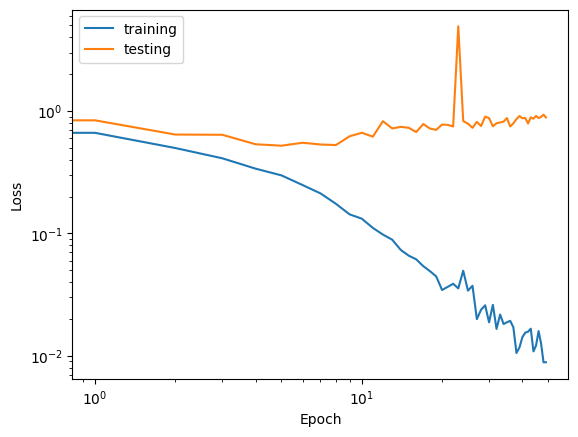

In [95]:
import matplotlib.pyplot as plt

plt.loglog(results["training_loss"], label="training")
plt.loglog(results["testing_loss"], label="testing")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc='best')
plt.show()

## Now calculate the confusion matrix on the `test` dataset



In [109]:
from sklearn.metrics import confusion_matrix

widgets = ['Evaluating on test dataset: ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = ProgressBar(widgets=widgets, maxval=1e4).start()

model.to("cpu")
model.eval()
# Gather all predictions on test dataset

predictions = []
gtruths = []
with torch.inference_mode():
  for _batch, (_input, _output) in pbar(enumerate(test_loader)):
    _input.to(DEVICE); _output.to(DEVICE)
    _prediction = model(_input)
    predictions.append(_prediction.argmax(dim=1))
    gtruths.append(_output.argmax(dim=1))

Evaluating on test dataset: 100% |#############################| Time:  0:01:00


In [ ]:
# Take just values from the first channel
pclass = []
gtclass = []
for pc, gtc in zip(predictions,gtruths):
  pclass.append(pc[0])
  gtclass.append(gtc[0])

In [122]:
pclass = [item.numpy() for item in pclass]
pclass = np.asarray(pclass,dtype=int)

In [124]:
gtclass = [item.numpy() for item in gtclass]
gtclass = np.asarray(gtclass,dtype=int)

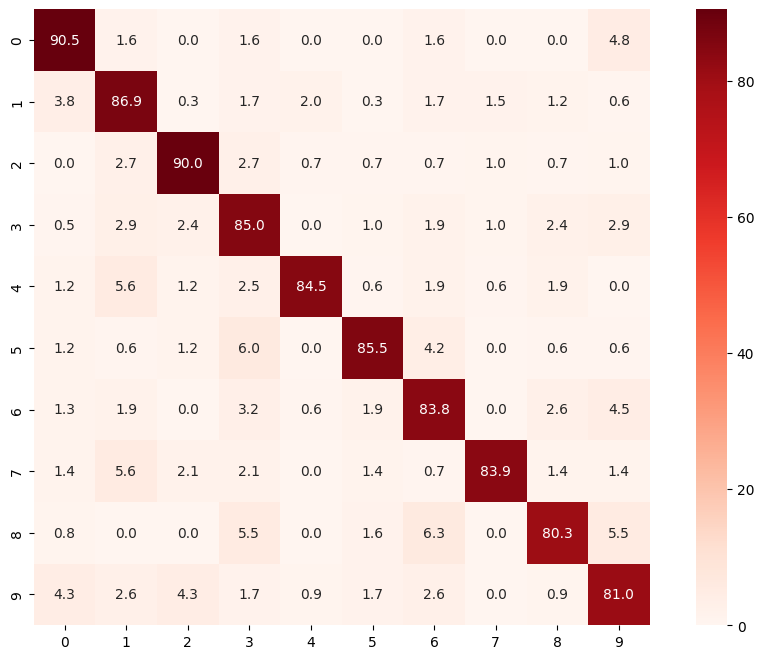

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=gtclass, y_pred=pclass)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);